In [22]:
import numpy as np
from random_mdp import MDPEnv, MDPEnvDiscreteRew, MDPEnvBernoulliRew
from agent import QlearningAgent
from greedy_policy import EpsilonGreedyPolicy, TableBasedPolicy, MixedPolicy
from utils import get_data, collect_exp, train_predictor, train_behaviour_policy, compute_weight, compute_weights_gradient, train_weight_function
from networks import MLP, WeightsMLP
from dynamics_model import DynamicsModel, DiscreteRewardDynamicsModel
import torch
from collections import defaultdict
import pickle
import random
from weights import WeightsEstimator
from conformal_set import ConformalSet
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seed(1)

REWARD_TYPE = "discrete_multiple"
GRADIENT_BASED = True
EPSILON = 0.3
QUANTILE = 0.1
LR = 1e-4
MOMENTUM = 0.9
EPOCHS = 100
NUM_ACTIONS = 5                                                                     # MDP action space size
NUM_STATES = 30                                                                     # MDP states space size
NUM_REWARDS = 10                                                                    # MDP reward space size (for discrete MDP)
DISCOUNT_FACTOR = 0.99                                                              # behaviour agent discount factor
ALPHA = 0.6                                                                         # behaviour agent alpha
NUM_STEPS = 10000                                                                   # behaviour agent learning steps
N_TRAJECTORIES = 20000                                                              # number of trajectories collected as dataset
HORIZON = 30                                                                        # trajectory horizon

P = np.random.dirichlet(np.ones(NUM_STATES), size=(NUM_STATES, NUM_ACTIONS))        # MDP transition probability functions

if REWARD_TYPE == "bernoulli":
    R = np.random.rand(NUM_STATES, NUM_ACTIONS)                                     # MDP reward function Bernoulli
    env = MDPEnvBernoulliRew(NUM_STATES, NUM_ACTIONS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "discrete_multiple":                                 
    R = np.random.dirichlet(np.ones(NUM_REWARDS), size=(NUM_STATES, NUM_ACTIONS))   # MDP reward function multiple discrete r values
    env = MDPEnvDiscreteRew(NUM_STATES, NUM_ACTIONS, NUM_REWARDS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "continuous":
    # TODO: implement continuous rewards model, the "true" MDP we already have
    R = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES)
    env = MDPEnv(NUM_STATES, NUM_ACTIONS, P, R)

pi_star_probs = np.random.dirichlet(np.ones(NUM_ACTIONS), size=(NUM_STATES))
pi_star_pre = TableBasedPolicy(pi_star_probs)


#Train behaviour policy using Q-learning
agent = QlearningAgent(env.ns, NUM_ACTIONS, DISCOUNT_FACTOR, ALPHA)

q_table = train_behaviour_policy(env, agent, NUM_STEPS)
behaviour_policy = EpsilonGreedyPolicy(q_table, EPSILON, NUM_ACTIONS)

#Collect experience data using behaviour policy and train model
#TODO: improve storage system
model, dataset = get_data(env, N_TRAJECTORIES, behaviour_policy, model, REWARD_TYPE, HORIZON)

#Split dataset into training (90%) and calibration data (10%)
calibration_trajectories = N_TRAJECTORIES // 10
data_tr = dataset[:N_TRAJECTORIES - calibration_trajectories]
data_cal = dataset[N_TRAJECTORIES - calibration_trajectories:N_TRAJECTORIES]
test_state = np.random.randint(NUM_STATES)

#Train quantile predictors using training dataset
print('> Training/loading quantile networks')
upper_quantile_net = MLP(1, 32, 1, False)
lower_quantile_net = MLP(1, 32, 1, False)

if not lower_quantile_net.load('./data/networks/lower_quantile_net.pth'):
    y_avg, y_std = train_predictor(lower_quantile_net, data_tr, epochs=EPOCHS, quantile=QUANTILE/2, lr=LR, momentum=MOMENTUM)
    lower_quantile_net.set_normalization(y_avg, y_std)
    lower_quantile_net.save('./data/networks/lower_quantile_net.pth')

if not upper_quantile_net.load('./data/networks/upper_quantile_net.pth'):
    y_avg, y_std = train_predictor(upper_quantile_net, data_tr, epochs=EPOCHS, quantile=1-(QUANTILE/2), lr=LR, momentum=MOMENTUM)
    upper_quantile_net.set_normalization(y_avg, y_std)
    upper_quantile_net.save('./data/networks/upper_quantile_net.pth')

> Loading/collecting data
> Training/loading quantile networks


In [23]:
from tqdm.notebook import tqdm

epsilons = np.linspace(0.05, 0.9, 10)
N_SIMS = 10

epsilon_avg_lengths = np.zeros((N_SIMS, len(epsilons)))
epsilon_std_lengths = np.zeros((N_SIMS, len(epsilons)))
coverages = np.zeros((N_SIMS, len(epsilons)))

for n in range(N_SIMS):
    print(f'Sim: {n}')
    for id_epsilon, epsilon_value in enumerate(epsilons):
        print(f'Epsilon = {epsilon_value}')
        pi_star = MixedPolicy(pi_star_pre, behaviour_policy, epsilon_value)
        test_points = collect_exp(env, 100, HORIZON, pi_star, None, test_state)

        print(f'> Estimate weights for calibration data')
        weights_estimator = WeightsEstimator(behaviour_policy, pi_star, lower_quantile_net, upper_quantile_net)
        if GRADIENT_BASED:
            scores, weights, weight_network = weights_estimator.gradient_method(data_tr, data_cal, LR, EPOCHS, lambda:WeightsMLP(2, 32, 1, upper_quantile_net.mean, upper_quantile_net.std))
        else:
            scores, weight = weights_estimator.model_based(data_tr, data_cal, HORIZON, model)

        # Generate y values for test point
        print(f'> Computing conformal set')
        conformal_set = ConformalSet(lower_quantile_net, upper_quantile_net, behaviour_policy, pi_star, model, HORIZON)
        y_set, intervals = conformal_set.build_set(test_points, weights, scores, weight_network, GRADIENT_BASED)

        included = 0
        lengths = []
        for interval in intervals:
            if interval[-1] >= interval[2] and interval[-1] <= interval[3]:
                included += 1
            lengths.append(interval[3]-interval[2])

        included = included/len(intervals)
        mean_length = np.mean(lengths)
        epsilon_avg_lengths[n, id_epsilon] = mean_length
        epsilon_std_lengths[n, id_epsilon] = np.std(lengths)
        coverages[n, id_epsilon] = included * 100
        print("Coverage: {:.2f}% | Average interval length: {}".format(included*100, mean_length))

Sim: 0
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.6950336689802725e-09 - Loss val: 9.228031558450311e-06: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


> Computing conformal set


/home/alessio/Conformal_OPE_MDP/conformal_set.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores)


Coverage: 84.00% | Average interval length: 52.636688232421875
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00014158579870127141 - Loss val: 0.0027246796526014805: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 52.584643328631365
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0010824616765603423 - Loss val: 0.07139793038368225: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 53.879241943359375
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 575.9190673828125 - Loss val: 0.5844688415527344: 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 53.32965087890625
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.030555393546819687 - Loss val: 2.5160441398620605: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 53.879241943359375
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 28.009193420410156 - Loss val: 7.516683101654053: 100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 52.480865478515625
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 27.834989547729492 - Loss val: 14.207870483398438: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.244842529296875
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.6543166637420654 - Loss val: 15.038280487060547: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 53.879241943359375
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.978098154067993 - Loss val: 6.925762176513672: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s] 


> Computing conformal set
Coverage: 87.00% | Average interval length: 55.219940185546875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.5199897289276123 - Loss val: 1.2811440229415894: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.932952880859375
Sim: 1
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.5579926682107725e-08 - Loss val: 9.227880582329817e-06: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 49.2816162109375
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.261581014157855e-07 - Loss val: 0.0027246393729001284: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.480865478515625
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.664857129275333e-05 - Loss val: 0.07110206037759781: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


> Computing conformal set
Coverage: 85.00% | Average interval length: 47.219940185546875
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00767184142023325 - Loss val: 0.5862401723861694: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s] 


> Computing conformal set
Coverage: 89.00% | Average interval length: 53.879241943359375
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.07669622451066971 - Loss val: 2.5561680793762207: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 55.230865478515625
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.1165356636047363 - Loss val: 7.638575077056885: 100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.636688232421875
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.5464155673980713 - Loss val: 14.242660522460938: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


> Computing conformal set
Coverage: 83.00% | Average interval length: 51.879241943359375
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.481043338775635 - Loss val: 14.514883995056152: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 53.789947509765625
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.3994481563568115 - Loss val: 7.720606327056885: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 56.244842529296875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.464587211608887 - Loss val: 2.232729196548462: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 53.610443115234375
Sim: 2
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 9.086981833661412e-09 - Loss val: 2.0866902559646405e-05: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 53.879241943359375
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 24.87457275390625 - Loss val: 24.974687576293945: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.95121765136719
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0001804350467864424 - Loss val: 0.07106224447488785: 100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 53.879241943359375
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.008777614682912827 - Loss val: 0.5864706039428711: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


> Computing conformal set
Coverage: 98.00% | Average interval length: 53.203521728515625
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0867493599653244 - Loss val: 2.519613742828369: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s] 


> Computing conformal set
Coverage: 87.00% | Average interval length: 52.55877685546875
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.2653120160102844 - Loss val: 7.384815692901611: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s] 


> Computing conformal set
Coverage: 92.00% | Average interval length: 52.244842529296875
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 8.701366424560547 - Loss val: 14.20776081085205: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.244842529296875
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 33.482669830322266 - Loss val: 32.654300689697266: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 53.021087646484375
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.352541923522949 - Loss val: 7.08589506149292: 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]  


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.636688232421875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.3683885335922241 - Loss val: 1.2824970483779907: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.636688232421875
Sim: 3
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.067331585451029e-06 - Loss val: 9.233307537215296e-06: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s] 


> Computing conformal set
Coverage: 84.00% | Average interval length: 51.879241943359375
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.238073524400534e-07 - Loss val: 0.0027247800026088953: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 57.24969482421875
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0005589778302237391 - Loss val: 0.07244741916656494: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 52.95121765136719
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0018679872155189514 - Loss val: 0.5842000842094421: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 52.636688232421875
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0018926298944279552 - Loss val: 2.523329973220825: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 56.244842529296875
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.2127633094787598 - Loss val: 7.360249996185303: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 53.203521728515625
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.03310489654541 - Loss val: 14.209345817565918: 100%|██████████| 100/100 [00:09<00:00, 10.53it/s] 


> Computing conformal set
Coverage: 84.00% | Average interval length: 49.76788330078125
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.8143470287323 - Loss val: 14.786149024963379: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]  


> Computing conformal set
Coverage: 93.00% | Average interval length: 52.25225830078125
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.199214458465576 - Loss val: 6.912703037261963: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.636688232421875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.688747763633728 - Loss val: 1.2840055227279663: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 52.932952880859375
Sim: 4
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.0176151294701867e-10 - Loss val: 9.228245289705228e-06: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.57281494140625
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.4053586710360833e-05 - Loss val: 0.002726783975958824: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 55.230865478515625
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0037127379328012466 - Loss val: 0.0711020678281784: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


> Computing conformal set
Coverage: 78.00% | Average interval length: 51.7060546875
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.028597116470336914 - Loss val: 0.5847054123878479: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 53.70808410644531
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 24.772912979125977 - Loss val: 26.393810272216797: 100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 52.480865478515625
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 205.4202117919922 - Loss val: 7.358420372009277: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 53.610443115234375
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.3560049533843994 - Loss val: 14.187739372253418: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


> Computing conformal set
Coverage: 84.00% | Average interval length: 52.55877685546875
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5023.2841796875 - Loss val: 14.515362739562988: 100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 59.610443115234375
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 12.848041534423828 - Loss val: 7.732881546020508: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.244842529296875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7507598400115967 - Loss val: 1.284764051437378: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.636688232421875
Sim: 5
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.104036346077919e-05 - Loss val: 1.3899852092436049e-05: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 53.28523084852431
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.2110867575975135e-05 - Loss val: 0.002734163776040077: 100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 53.879241943359375
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00013978462084196508 - Loss val: 0.07129443436861038: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


> Computing conformal set
Coverage: 85.00% | Average interval length: 52.932952880859375
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0022973681334406137 - Loss val: 0.5844678282737732: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.174346923828125
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7178807258605957 - Loss val: 2.5824403762817383: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 53.879241943359375
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 18.359134674072266 - Loss val: 7.4920525550842285: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 56.244842529296875
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 39.094417572021484 - Loss val: 14.056718826293945: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.55877685546875
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.962667942047119 - Loss val: 15.041186332702637: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


> Computing conformal set
Coverage: 84.00% | Average interval length: 48.182098388671875
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 16.141664505004883 - Loss val: 6.968414783477783: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.95121765136719
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 16.757556915283203 - Loss val: 17.43288803100586: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 53.021087646484375
Sim: 6
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.1685201251054878e-08 - Loss val: 9.227873306372203e-06: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


> Computing conformal set
Coverage: 85.00% | Average interval length: 54.65899658203125
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00019181247625965625 - Loss val: 0.002724619349464774: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 54.65899658203125
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0005540026468224823 - Loss val: 0.07135851681232452: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 52.17240736219618
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.008843563497066498 - Loss val: 0.5874478220939636: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


> Computing conformal set
Coverage: 85.00% | Average interval length: 52.25225830078125
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.721505641937256 - Loss val: 2.700695037841797: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.25225830078125
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.3374861180782318 - Loss val: 7.352841854095459: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s] 


> Computing conformal set
Coverage: 86.00% | Average interval length: 52.636688232421875
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 10.275032043457031 - Loss val: 14.16303539276123: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 52.25225830078125
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 71.79219055175781 - Loss val: 15.038304328918457: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.244842529296875
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.133054733276367 - Loss val: 7.731407642364502: 100%|██████████| 100/100 [00:09<00:00, 10.66it/s] 


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.25225830078125
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.147088050842285 - Loss val: 1.2911314964294434: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 52.57281494140625
Sim: 7
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.503170944441081e-07 - Loss val: 9.241128282155842e-06: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s] 


> Computing conformal set
Coverage: 89.00% | Average interval length: 53.879241943359375
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.001957549713551998 - Loss val: 0.0027302135713398457: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 52.636688232421875
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.020924165844917297 - Loss val: 0.07110211998224258: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


> Computing conformal set
Coverage: 80.00% | Average interval length: 52.95121765136719
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7711547017097473 - Loss val: 0.5844678282737732: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


> Computing conformal set
Coverage: 96.00% | Average interval length: 52.244842529296875
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.2597445547580719 - Loss val: 2.6068336963653564: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 53.610443115234375
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.466156542301178 - Loss val: 7.38456392288208: 100%|██████████| 100/100 [00:09<00:00, 10.63it/s]   


> Computing conformal set
Coverage: 88.00% | Average interval length: 53.879241943359375
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 88.98615264892578 - Loss val: 14.048500061035156: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 54.65899658203125
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 51.124908447265625 - Loss val: 14.908942222595215: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 54.32051086425781
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.1985971927642822 - Loss val: 6.906510829925537: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 52.55877685546875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.9010125398635864 - Loss val: 1.2780407667160034: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 54.65899658203125
Sim: 8
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 9.83608788374113e-06 - Loss val: 9.711443453852553e-06: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]  


> Computing conformal set
Coverage: 88.00% | Average interval length: 53.185211181640625
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 24.874265670776367 - Loss val: 24.974687576293945: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.25225830078125
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0018320835661143064 - Loss val: 0.0718248188495636: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.25225830078125
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.010538255795836449 - Loss val: 0.5882157683372498: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 54.30487060546875
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7075933814048767 - Loss val: 2.519453763961792: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


> Computing conformal set
Coverage: 84.00% | Average interval length: 52.932952880859375
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 18.99758529663086 - Loss val: 7.384516716003418: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 51.610443115234375
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.800888538360596 - Loss val: 14.207765579223633: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 49.76788330078125
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 51.763458251953125 - Loss val: 15.038288116455078: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 53.879241943359375
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 17.264440536499023 - Loss val: 6.906679153442383: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 52.096435546875
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.4762086868286133 - Loss val: 2.2340972423553467: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 52.55877685546875
Sim: 9
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 7.4032841439475305e-06 - Loss val: 1.0671104064385872e-05: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 52.932952880859375
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 8.15309613244608e-06 - Loss val: 0.002726532518863678: 100%|██████████| 100/100 [00:10<00:00,  9.13it/s]  


> Computing conformal set
Coverage: 87.00% | Average interval length: 53.610443115234375
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0017891018651425838 - Loss val: 0.07110206037759781: 100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 55.834228515625
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.32318779826164246 - Loss val: 0.5844556093215942: 100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.57281494140625
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.03915591537952423 - Loss val: 2.5208992958068848: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 52.244842529296875
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 8999.2158203125 - Loss val: 7.440488338470459: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 55.219940185546875
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 25.105636596679688 - Loss val: 14.20776081085205: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 51.230865478515625
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 57.944671630859375 - Loss val: 32.654293060302734: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 52.95121765136719
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 21.553691864013672 - Loss val: 23.638029098510742: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 53.021087646484375
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.96822452545166 - Loss val: 2.232729196548462: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]  


> Computing conformal set
Coverage: 86.00% | Average interval length: 51.610443115234375


(10, 10)

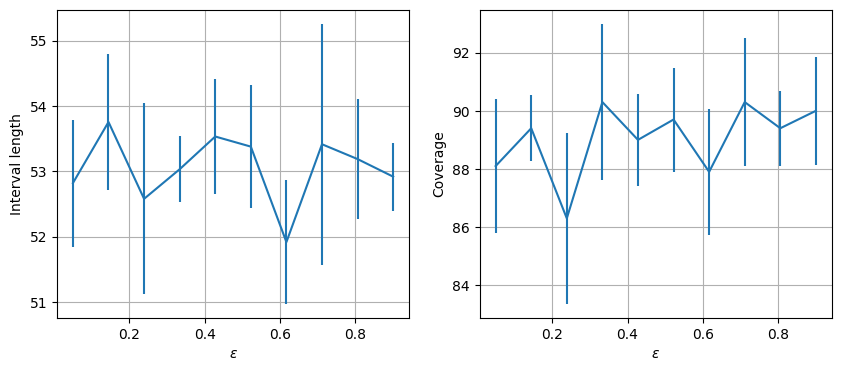

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].errorbar(epsilons, epsilon_avg_lengths.mean(0), 2.2*epsilon_avg_lengths.std(0) / np.sqrt(epsilon_avg_lengths.shape[0]))
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Interval length')
ax[0].grid()


ax[1].errorbar(epsilons, coverages.mean(0), 2.2*coverages.std(0) / np.sqrt(coverages.shape[0]))
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Coverage')
ax[1].grid()
plt.savefig('results.pdf')